# Raster Gap Filling

In this tutorial we will fill **no-data** gaps in a series of rasters, using different functions provided by `eumap.gapfiller`.

First, let's import the necessary modules.

In [1]:
import sys

# Add the repository root in the path
# If the eumap isn't instaled you should do it   
sys.path.append('../../')

from eumap import datasets
from eumap.misc import find_files
from eumap import raster
from eumap import gapfiller

datasets.pilot.TILES

['10636_switzerland',
 '14576_netherlands',
 '14580_netherlands',
 '15560_poland',
 '16057_ireland',
 '22497_sweden',
 '4582_spain',
 '5606_greece',
 '9326_italy',
 '9529_croatia']

We will use a time-series of LANDSAT raster for Sweden, downloading the raster data from [Zenodo](https://zenodo.org/record/4058447).

In [2]:
tile = datasets.pilot.TILES[5]
datasets.pilot.get_data(tile+'_rasters.tar.gz')

Now, let's generate a list of file paths sorted by time, starting from the oldest raster.

In [3]:
from pathlib import Path
import os

def get_fn_rasters(tile, band, perc):
    
    data_root = datasets.DATA_ROOT_NAME
    tile_dir = Path(os.getcwd()).joinpath(data_root, tile) # datasets.pilot.get_data() downloads to the current working directory by default
        
    seasons = ['winter', 'spring', 'summer', 'fall']
    
    fn_rasters = []
    for year in range(2000, 2020):
        for season in seasons:
            fn_rasters += find_files(dir_list=tile_dir, pattern=f'{year}/landsat*{season}*{band}*{perc}*.tif')
    
    print(f'Total number of files: {len(fn_rasters)}')
    print(f'- First file: {fn_rasters[0]}')
    print(f'- Last file: {fn_rasters[len(fn_rasters)-1]}')
    
    return fn_rasters

perc = 'p50'
band = 'nir'
# we will use the 50th percentile of the LANDSAT NIR band provided in the eumap datasets.tiles
fn_rasters = get_fn_rasters(tile, band, perc)

Total number of files: 80
- First file: /home/jupyter/leandro/Code/eumap/docs/notebooks/eumap_data/22497_sweden/2000/landsat_ard_winter_nir_p50.tif
- Last file: /home/jupyter/leandro/Code/eumap/docs/notebooks/eumap_data/22497_sweden/2019/landsat_ard_fall_nir_p50.tif


## Temporal Moving Window Median (TMWM)

This method works in the **temporal domain**, using different combinations of temporal moving window (based in the parameter `time_win_size`) to calculate several median values, prioritizing them in three phases of gap filling attempts. The **phase 1** uses only observations of the same season/month/day in different years, doubling the temporal moving window until find some available median value to fill the gap. If all the values of the same season/month/day are no-data, the **phase 2** applies the same approach considering the average between the two neighborhood season(s)/month(s)/day(s). The **phase 3** tries to fill the gap using a median value calculated with all observations available in different years. If a specific pixel has only no-data value in all the observation (a no-data time-series) the gap will remaining after all TMWM attempts:

![TMWM](https://gitlab.com/geoharmonizer_inea/eumap/-/raw/master/img/tmwm.png?inline=false "Gap filling example for two pixels using TMWM and the time_win_size=4")

In [4]:
tmwm = gapfiller.TMWM(fn_files=fn_rasters, season_size=4, time_win_size=9, std_env=2, outlier_remover=gapfiller.OutlierRemover.Std)
data_tmwm = tmwm.run()
fn_rasters_tmwm = tmwm.save_rasters('./gapfilled_tmwm', dtype='uint8', save_flag=True)

[15:28:14] Reading 80 raster files using 4 workers
[15:28:18] There are 29925745 gaps in (1000, 1000, 80)
[15:28:18] Removing temporal outliers using OutlierRemover.Std
[15:31:37] 2487061 outliers removed
[15:31:38] There are 32412806 gaps in (1000, 1000, 80)
[15:31:38] Data (1000, 1000, 20) organized in time=0
[15:31:38] Data (1000, 1000, 20) organized in time=1
[15:31:38] Data (1000, 1000, 20) organized in time=2
[15:31:39] Data (1000, 1000, 20) organized in time=3
[15:31:39] Calculating 152 gap filling possibilities
[15:31:39] Using cpu engine
[15:31:41] Possibilities calculated
[15:31:47] 100.00% of the gaps filled in 209.12 segs
[15:31:50] Number of files saved in gapfilled_tmwm: 160


You can check that **all the gaps** were filled and *160 raster files* were saved, 80 files with the gapfilled time series data and 80 files containing the size of the **temporal moving window used** to fill the gap.

Let's plot the result for a specific pixels:

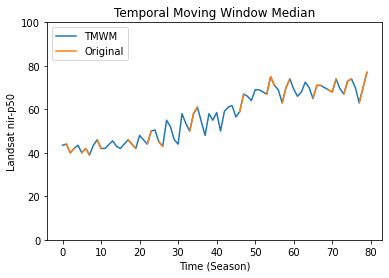

In [5]:
import matplotlib.pyplot as plt

# pixel position in the numpy array
x, y = 50, 50

plt.plot(tmwm.gapfilled_data[x, y, :], label='TMWM')
plt.plot(tmwm.data[x, y, :], label='Original')

plt.title('Temporal Moving Window Median')
plt.ylabel(f'Landsat {band}-{perc}')
plt.xlabel('Time (Season)')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

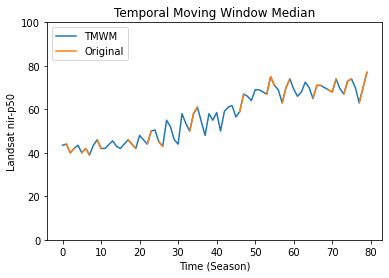

In [6]:
import matplotlib.pyplot as plt

# pixel position in the numpy array
x, y = 50, 50

plt.plot(tmwm.gapfilled_data[x, y, :], label='TMWM')
plt.plot(tmwm.data[x, y, :], label='Original')

plt.title('Temporal Moving Window Median')
plt.ylabel(f'Landsat {band}-{perc}')
plt.xlabel('Time (Season)')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

It's possible check the the size of the moving windown used to calculated the median value:
* **Same season**: values between 0 and n_years (ex: ``pixel_value=4`` and ``window_size=4``)
* **Neighborhood seasons**: values between n_years and n_years*2 (ex: ``pixel_value=24`` and ``window_size=4``)
* **All seasons**: values between n_years*2 and n_years*3 (ex: ``pixel_value=44`` and ``window_size=4``)

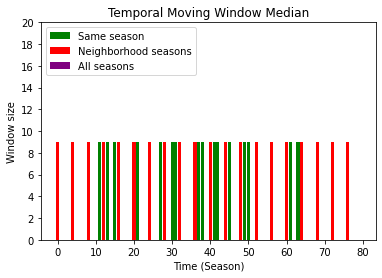

In [7]:
import numpy as np
from matplotlib.ticker import MaxNLocator

def plt_bar(time_flag, tmwm_flag, mask_flag, color, label, rescale_factor):
    masked_tmwm_flag = np.zeros(ts_size)
    masked_tmwm_flag[mask_flag] = tmwm_flag[mask_flag] - rescale_factor
    plt.bar(time_flag, masked_tmwm_flag, color=color, label=label)

tmwm_flag = tmwm.gapfilled_data_flag[x, y, :]

ts_size = len(tmwm_flag)
season_size = 4
n_years = (ts_size / season_size)
time_flag = range(0, ts_size)

same_season_mask = (tmwm_flag < n_years)
plt_bar(time_flag, tmwm_flag, same_season_mask, 'Green', 'Same season', 0)

neib_season_mask = np.logical_and((tmwm_flag >= n_years), (tmwm_flag < n_years*2))
plt_bar(time_flag, tmwm_flag, neib_season_mask, 'Red', 'Neighborhood seasons', n_years)

all_season_mask = (tmwm_flag >= n_years*2)
plt_bar(time_flag, tmwm_flag, all_season_mask, 'Purple', 'All seasons', n_years*2)

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Temporal Moving Window Median')
plt.ylabel(f'Window size')
plt.xlabel('Time (Season)')
plt.legend(loc="upper left")
plt.ylim([0, 20])
plt.show()

## Temporal Linear Interpolation (TLI)

This method works in the **temporal domain**, using a linear regression ([LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) over the time to interpolate the no-data values:

In [8]:
tli = gapfiller.TLI(fn_files=fn_rasters)
data_tli = tli.run()
fn_rasters_tli = tli.save_rasters('./gapfilled_tli', dtype='uint8')

[15:31:52] Reading 80 raster files using 4 workers
[15:31:56] There are 29925745 gaps in (1000, 1000, 80)
[15:32:54] 100.00% of the gaps filled in 58.02 segs
[15:32:58] Number of files saved in gapfilled_tli: 160


You can check that **all the gaps** were filled and 160 raster files were saved, 80 files with the gapfilled time series data and 80 files containing the `Root Mean Square Error` of the fitted regression.

Let's plot the result for a specific pixels:

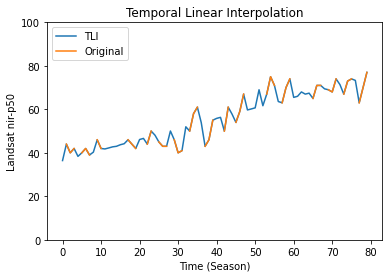

In [9]:
import matplotlib.pyplot as plt

# pixel position in the numpy array
x, y = 50, 50

plt.plot(tli.gapfilled_data[x, y, :], label='TLI')
plt.plot(tli.data[x, y, :], label='Original')

plt.title('Temporal Linear Interpolation')
plt.ylabel(f'Landsat {band}-{perc}')
plt.xlabel('Time (Season)')
plt.legend(loc="upper left")
plt.ylim([0, 100])
plt.show()

It's also possible retrieve the **RMSE** for the fitted regression, which will change in the space:

In [10]:
print(f'RMSE:')
print(f' -Pixels {x-1} {y-1}: {tli.gapfilled_data_flag[x-1, y-1, 0]:.3f}')
print(f' -Pixels {x} {y}: {tli.gapfilled_data_flag[x, y, 0]:.3f}')
print(f' -Pixels {x+1} {y+1}: {tli.gapfilled_data_flag[x+1, y+1, 0]:.3f}')

RMSE:
 -Pixels 49 49: 4.063
 -Pixels 50 50: 5.486
 -Pixels 51 51: 6.593


## InPainting

This method works in the **spatial domain**, using the neighbouring pixels to fill the no-data values through a [Inpainting](https://en.wikipedia.org/wiki/Inpainting) technique implemented by [OpenCV](https://docs.opencv.org/4.5.2/df/d3d/tutorial_py_inpainting.html). If the you provide a ``data_mask`` argument (*2D array indicating a valid areas, equal 1*) only the missing values inside the mask will be gapfilled. 

In [11]:
inpaint = gapfiller.InPainting(fn_files=fn_rasters, space_win = 10)
data_inpaint = inpaint.run()
fn_rasters_inpaint = inpaint.save_rasters('./gapfilled_inpaint', dtype='uint8')

[15:32:59] Reading 80 raster files using 4 workers
[15:33:02] There are 29925745 gaps in (1000, 1000, 80)
[15:33:59] 23.14% of the gaps filled in 56.71 segs
[15:34:00] Remained gaps: 23000000
[15:34:04] Number of files saved in gapfilled_inpaint: 160


You can check that just **23.14%** of the gaps were filled. It occurred because in some images all the pixel are no-data, not being able to find any neighboring pixels.

## Gapfilled Raster Data

Now it's time to compare the gapfilled data produced by the three approaches:

Image: /home/jupyter/leandro/Code/eumap/docs/notebooks/eumap_data/22497_sweden/2008/landsat_ard_fall_nir_p50.tif


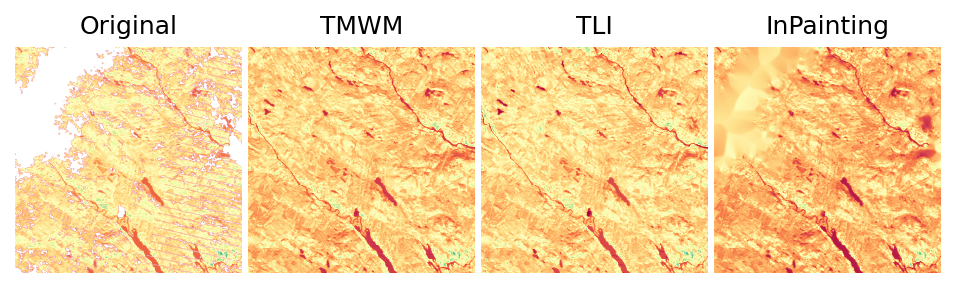

In [12]:
from eumap import plotter

i = 35
img_gaps = fn_rasters[i]
img_gapfilled_tmwm = fn_rasters_tmwm[i]
img_gapfilled_tli = fn_rasters_tli[i]
img_gapfilled_inpaint = fn_rasters_inpaint[i]

print(f'Image: {img_gaps}')
plotter.plot_rasters(
    img_gaps,
    img_gapfilled_tmwm,
    img_gapfilled_tli,
    img_gapfilled_inpaint,
    cmaps='Spectral',
    figsize=8,
    titles=['Original', 'TMWM', 'TLI', 'InPainting'],
)

Let's also look in the rasters containing the metadata information about the gapfilling approach:

Image: /home/jupyter/leandro/Code/eumap/docs/notebooks/eumap_data/22497_sweden/2008/landsat_ard_fall_nir_p50.tif


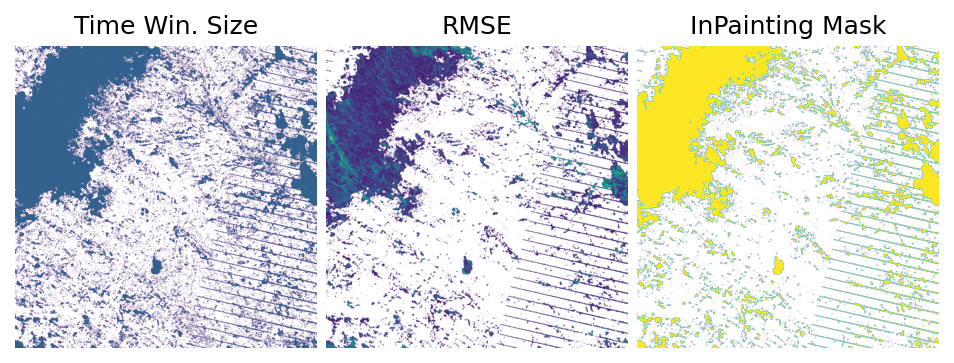

In [13]:
from eumap import plotter

flag_offset = len(fn_rasters)
flag_i = flag_offset + i 

img_gapfilled_tmwm_flag = fn_rasters_tmwm[flag_i]
img_gapfilled_tli_flag = fn_rasters_tli[flag_i]
img_gapfilled_inpaint_flag = fn_rasters_inpaint[flag_i]

print(f'Image: {img_gaps}')
plotter.plot_rasters(
    img_gapfilled_tmwm_flag,
    img_gapfilled_tli_flag,
    img_gapfilled_inpaint_flag,
    cmaps='viridis',
    figsize=8,
    titles=['Time Win. Size', 'RMSE', 'InPainting Mask'],
)

## Time first, space later

It's possible combine two or more gapfilling though the properties `gapfilled_data` and `data`. To illustrate it we will use the Switzerland tile:

In [14]:
tile = datasets.pilot.TILES[0]
datasets.pilot.get_data(tile+'_rasters.tar.gz')
fn_rasters = get_fn_rasters(tile, 'nir', 'p50')

Total number of files: 80
- First file: /home/jupyter/leandro/Code/eumap/docs/notebooks/eumap_data/10636_switzerland/2000/landsat_ard_winter_nir_p50.tif
- Last file: /home/jupyter/leandro/Code/eumap/docs/notebooks/eumap_data/10636_switzerland/2019/landsat_ard_fall_nir_p50.tif


...and execute first the `TMWM` approach and later the `InPainting` through the helper function ``time_first_space_later``:

In [15]:
tfsl = gapfiller.time_first_space_later(
    fn_files = fn_rasters,
    time_strategy = gapfiller.TMWM,
    time_args = { 'season_size': 4 },
    space_strategy = gapfiller.InPainting,
    space_args = { 'space_win': 10 }
)

fn_rasters_tfsl  = tfsl.save_rasters('./gapfilled_tmwm_inpaint', dtype='uint8', fn_files=fn_rasters)

[15:34:06] Reading 80 raster files using 4 workers
[15:34:10] There are 32165604 gaps in (1000, 1000, 80)
[15:34:10] Data (1000, 1000, 20) organized in time=0
[15:34:11] Data (1000, 1000, 20) organized in time=1
[15:34:11] Data (1000, 1000, 20) organized in time=2
[15:34:11] Data (1000, 1000, 20) organized in time=3
[15:34:11] Calculating 152 gap filling possibilities
[15:34:11] Using cpu engine
[15:34:13] Possibilities calculated
[15:34:20] 97.23% of the gaps filled in 9.71 segs
[15:34:20] Remained gaps: 892084
[15:34:22] There are 892084 gaps in (1000, 1000, 80)
[15:34:29] 100.00% of the gaps filled in 6.94 segs
[15:34:32] Number of files saved in gapfilled_tmwm_inpaint: 160


Now, let's check the result:

Image: /home/jupyter/leandro/Code/eumap/docs/notebooks/eumap_data/10636_switzerland/2012/landsat_ard_fall_nir_p50.tif


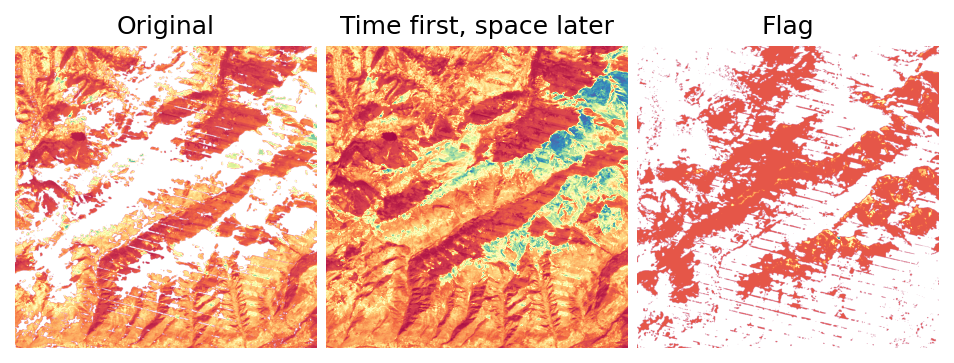

In [16]:
from eumap import plotter

i = 51
flag_offset = len(fn_rasters)
flag_i = flag_offset + i 

img_gaps = fn_rasters[i]
img_gapfilled_tfsl = fn_rasters_tfsl[i]
img_gapfilled_flag_tfsl = fn_rasters_tfsl[flag_i]


print(f'Image: {img_gaps}')
plotter.plot_rasters(
    img_gaps,
    img_gapfilled_tfsl,
    img_gapfilled_flag_tfsl,
    cmaps='Spectral',
    figsize=8,
    titles=['Original', 'Time first, space later', 'Flag'],
)